# Multivariate ITS model for a saturated market

## Business problem

## Notebook setup

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.product_incrementality.mv_its import MVITS

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("default")
plt.rcParams["figure.figsize"] = [12, 6]
rng = np.random.default_rng(42)

## Synthetic data generation

In [4]:
def generate_data(
    scenario: str,
    rng: np.random.Generator,
    MEAN_TOTAL_SALES,
    total_sales_sigma=20,
    n_first=20,
    n_time=60,
):
    """Generates a synthetic dataset based on the given rates."""

    # Determine market shares
    if scenario == "simple":
        rates = np.array(
            n_first * [[0.6, 0.4, 0]] + (n_time - n_first) * [[0.55, 0.35, 0.1]]
        )
    elif scenario == "complex":
        rates = np.array(
            n_first * [[0.6, 0.4, 0]]
            + (n_time - n_first) * [[0.65, 0.35, 0]]
            + 100 * [[0.55, 0.35, 0.1]]
        )

    # Generate total sales
    total = (
        rng.normal(loc=MEAN_TOTAL_SALES, scale=total_sales_sigma, size=n_time)
    ).astype(int)
    # Ensure total sales are non-negative
    total[total < 0] = 0
    # Generate sales counts
    counts = rng.multinomial(total, rates)

    # Convert to DataFrame
    data_wide = pd.DataFrame(counts)
    data_wide.columns = ["competitor", "own", "new"]
    data_wide.columns.name = "product"
    data_wide.index.name = "day"
    data_wide["pre"] = data_wide.index < n_first

    return data_wide

In [5]:
data = generate_data(
    "simple", rng, MEAN_TOTAL_SALES=1000, n_time=60, n_first=20, total_sales_sigma=20
)

In [6]:
data.head()

product,competitor,own,new,pre
day,,,,
0,602,404,0,True
1,579,400,0,True
2,621,394,0,True
3,619,399,0,True
4,582,378,0,True


In [7]:
def plot_data(df, ax):
    df.plot(ax=ax, drawstyle="steps-post")
    # ax.axvline(n_first, linestyle="--", color="gray", zorder=-10)
    # df.sum(axis=1).plot(label="total sales", color="black", ax=ax)
    ax.set_ylim(bottom=0)

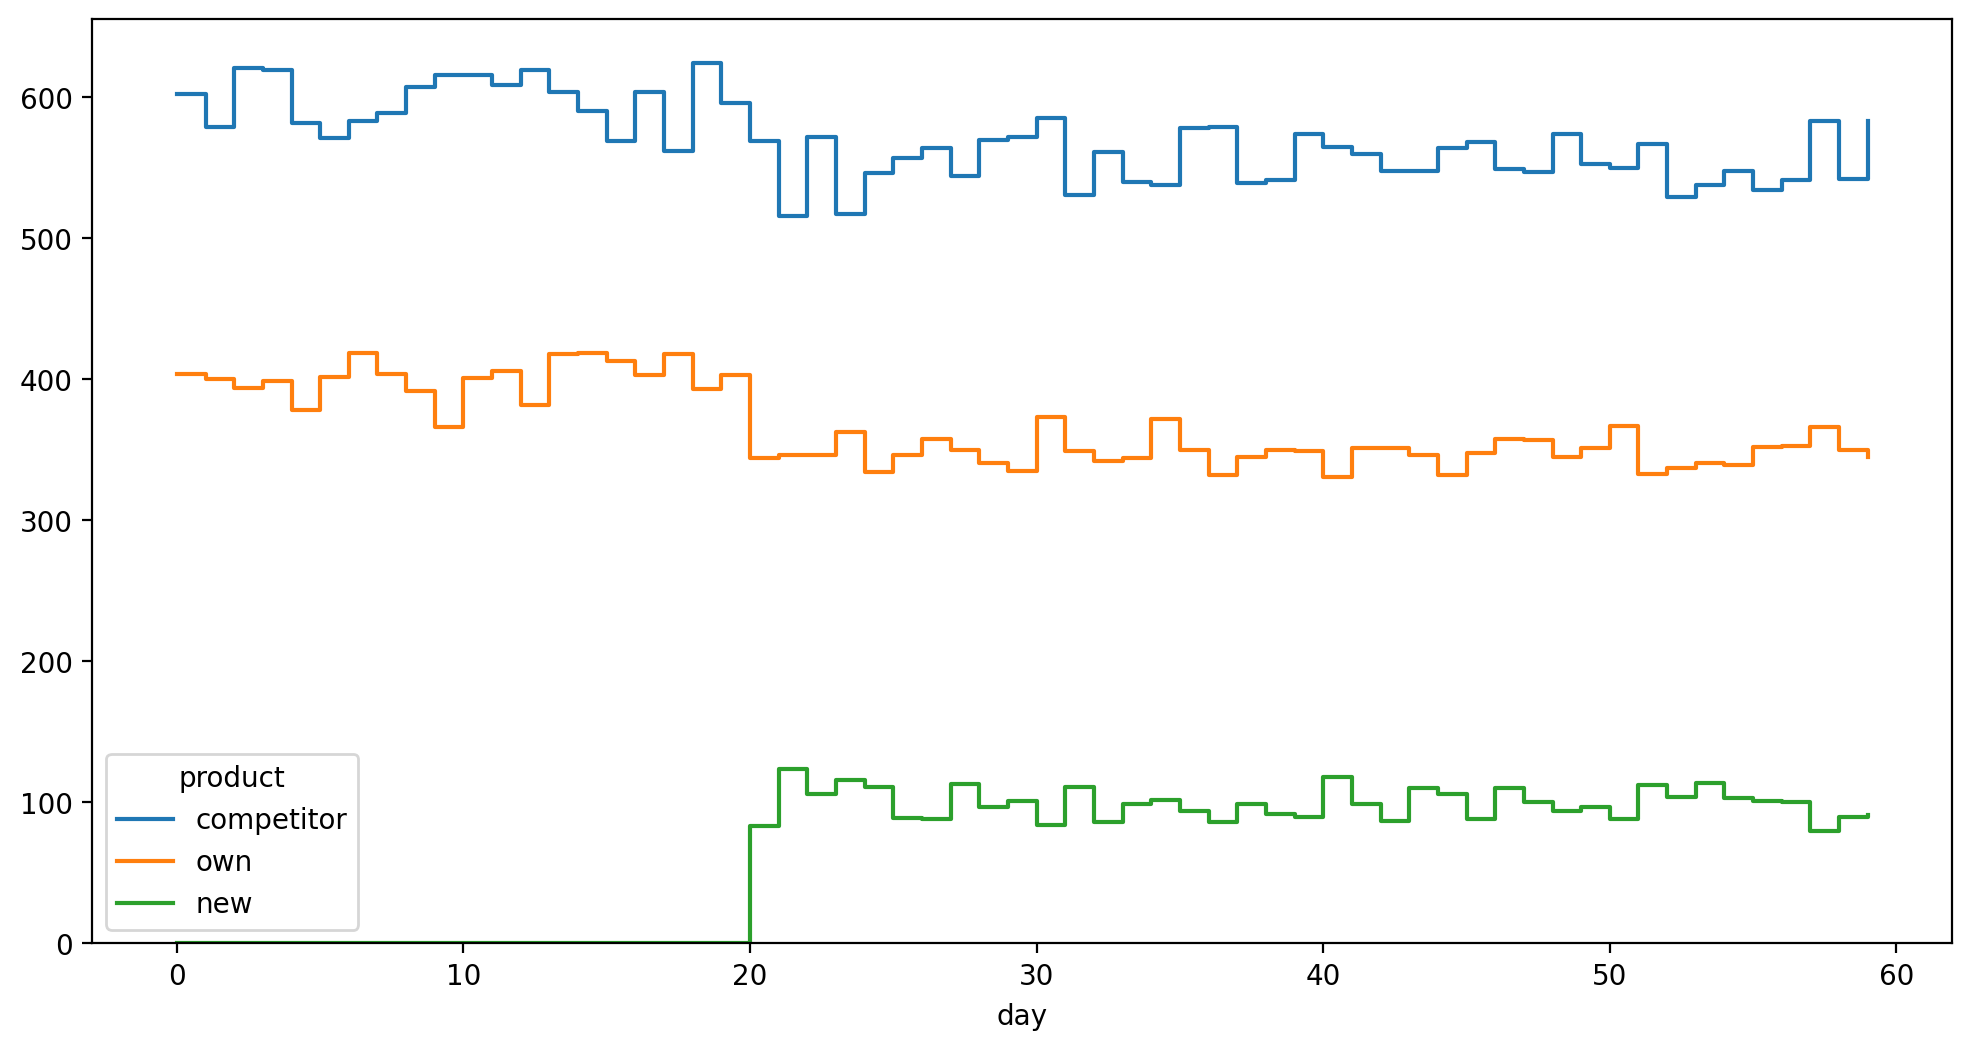

In [8]:
fig, ax = plt.subplots()
plot_data(data, ax)

## Model building and fitting

In [9]:
result = MVITS(
    data,
    treatment_time=100,
    background_sales=["competitor", "own"],
    innovation_sales="new",
    rng=rng,
)

/Users/benjamv/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc/data.py:423: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, background_product_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

Sampling: [y]


Output()

## Model diagnostics

Let's check the traces of the parameters to see if they are stationary, and to see if the posteriors are well mixed.

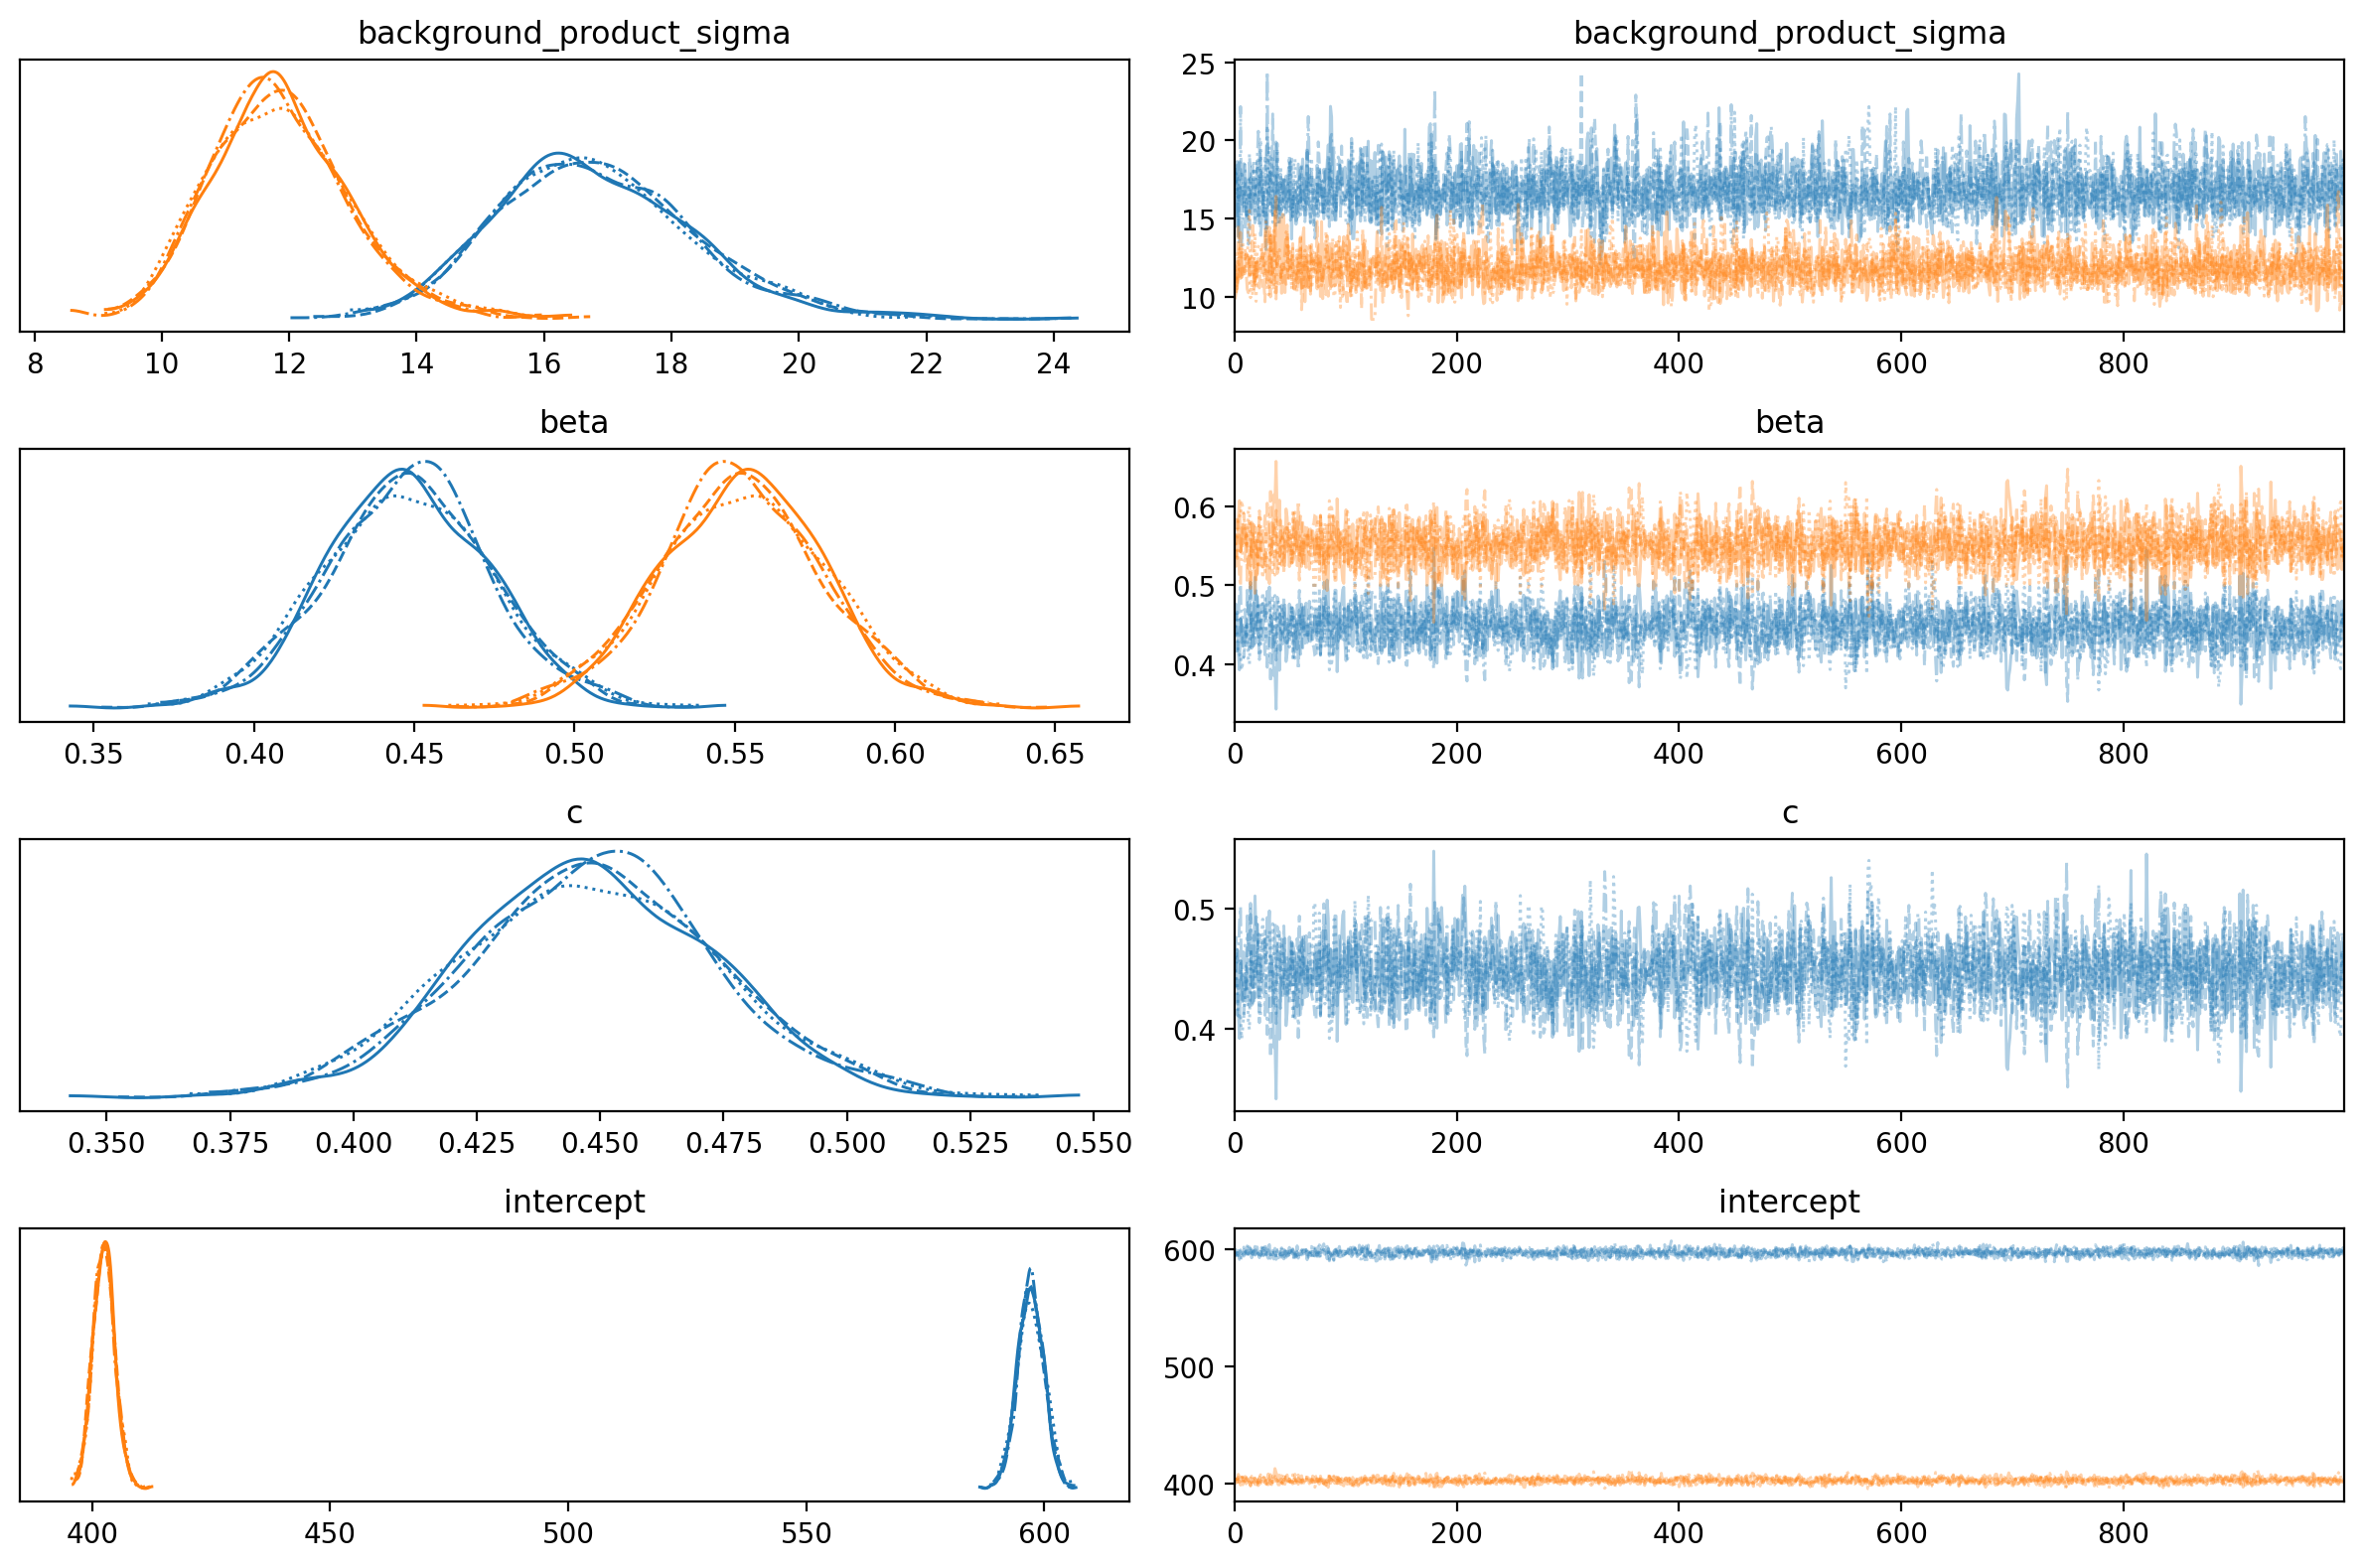

In [10]:
az.plot_trace(result.idata, var_names="~mu")
plt.tight_layout()

## Model results

Let's (visually) evaluate to what extent the model can account for the sales data by plotting posterior predictive fits.

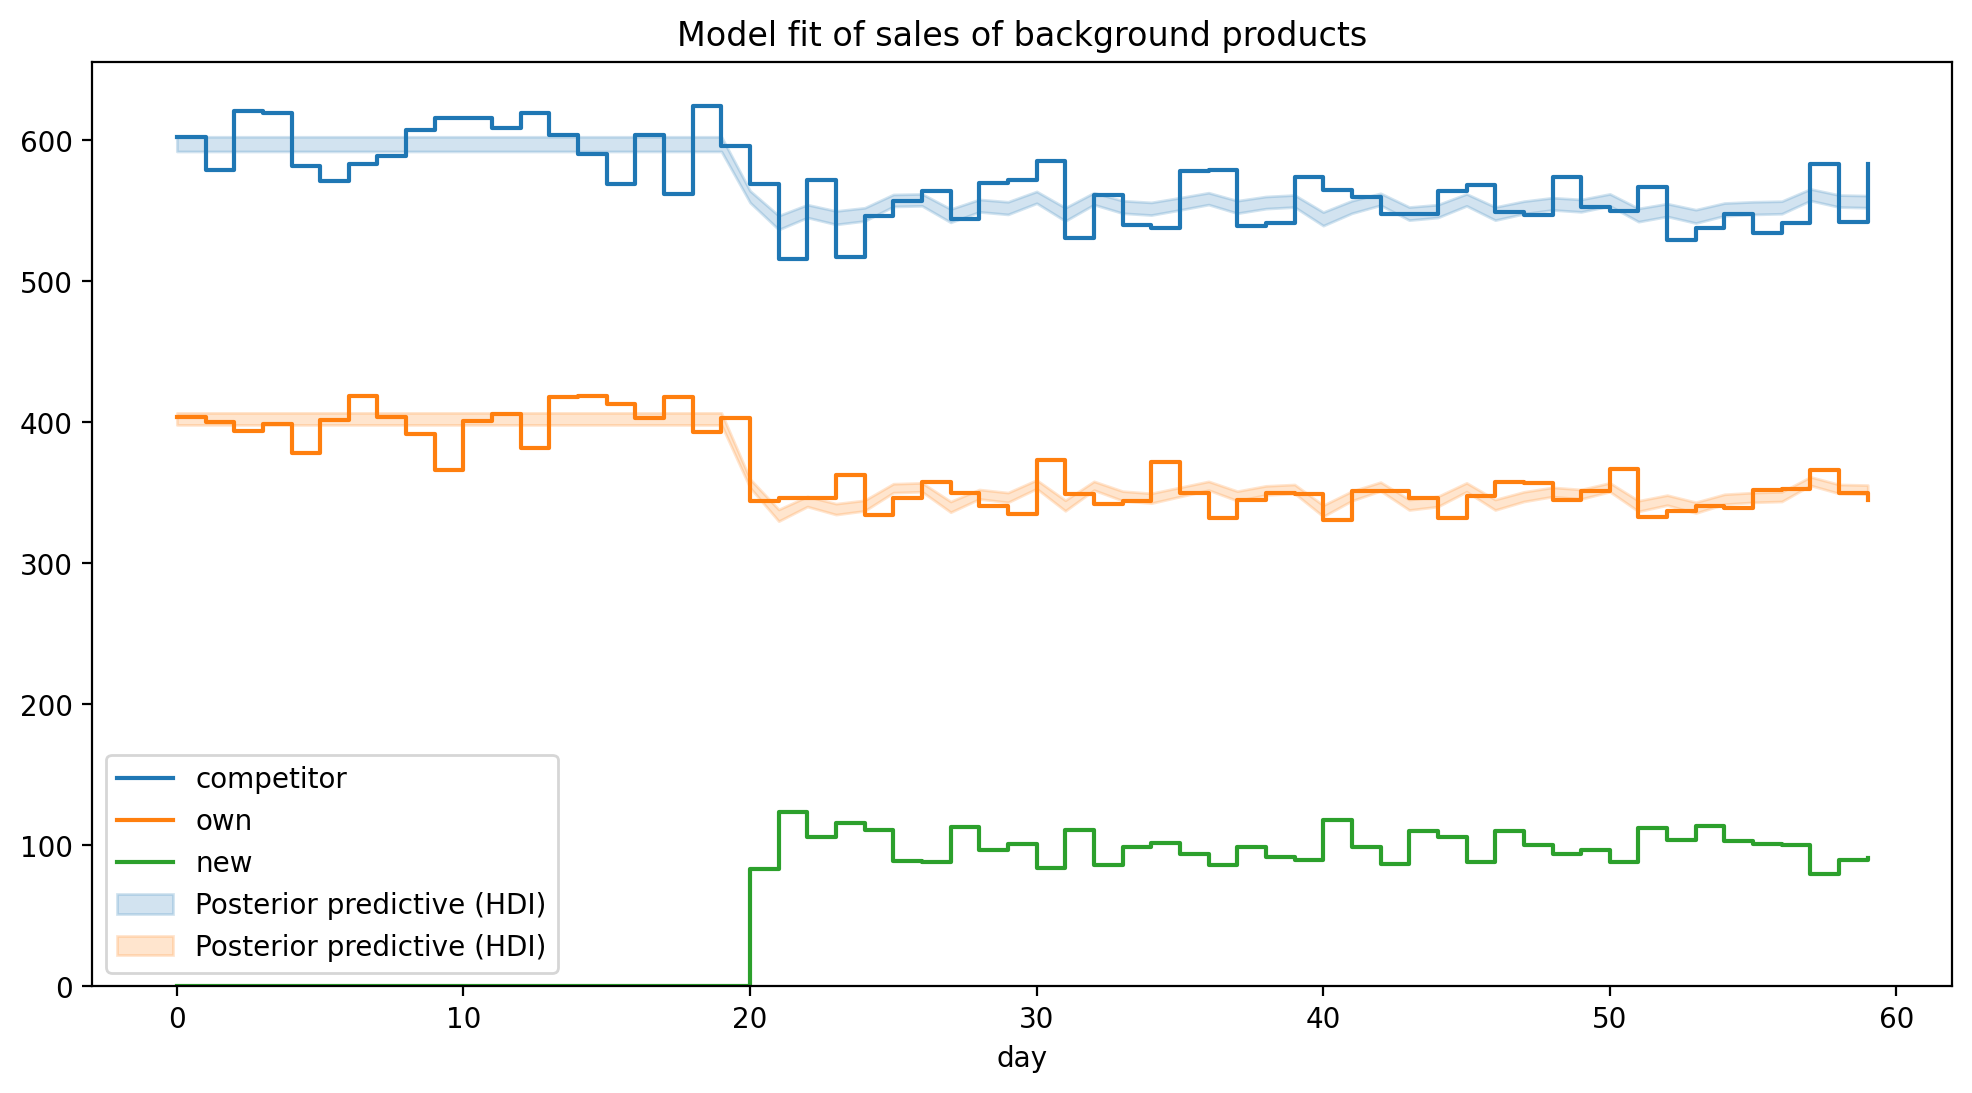

In [11]:
result.plot_fit()

Now let's look at the model's predicted sales in the counterfactual scenario where the company did not launch the new product. Internally, this is done by setting the sales of the new product to zero in the model's input data.

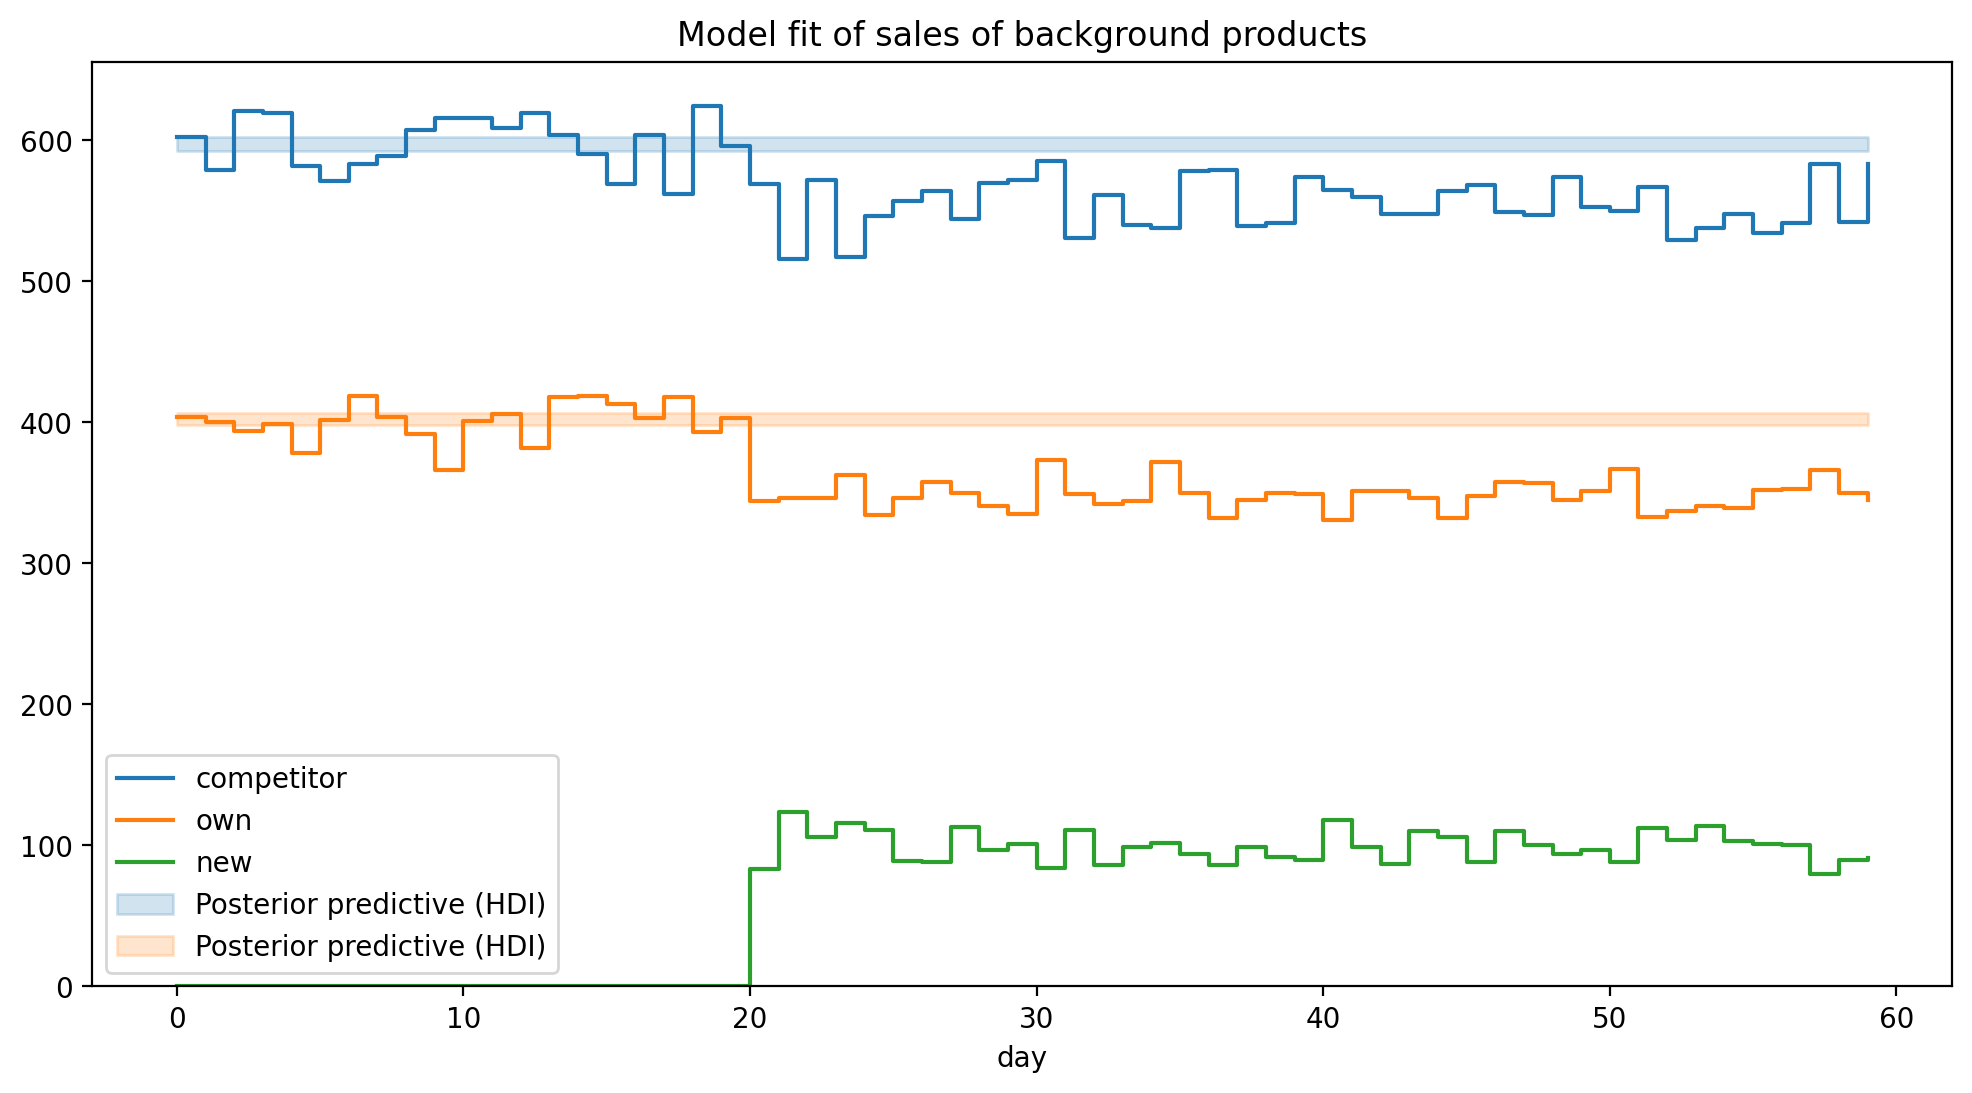

In [12]:
result.plot_counterfactual()

By comparing the two, we have our estimated causal impacts (upon each of the existing products) of the new product launch.

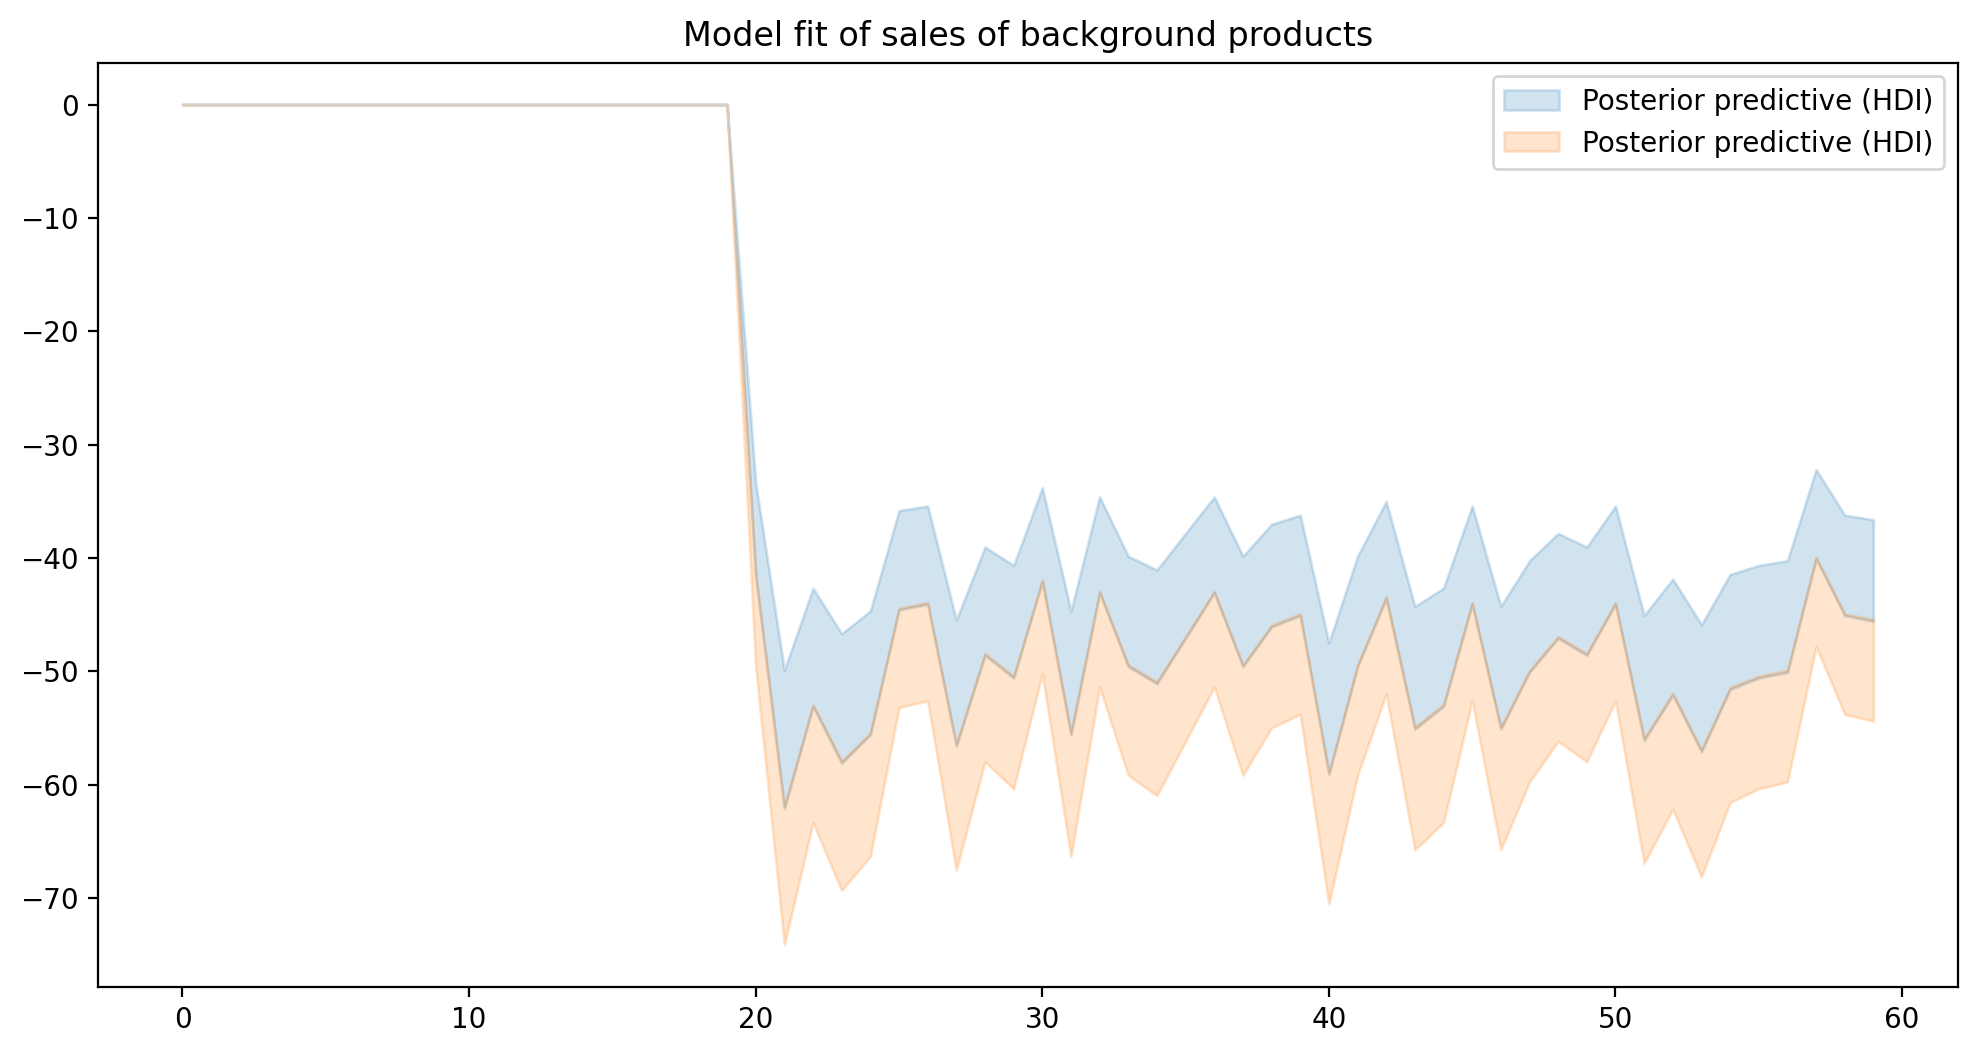

In [13]:
result.plot_causal_impact()

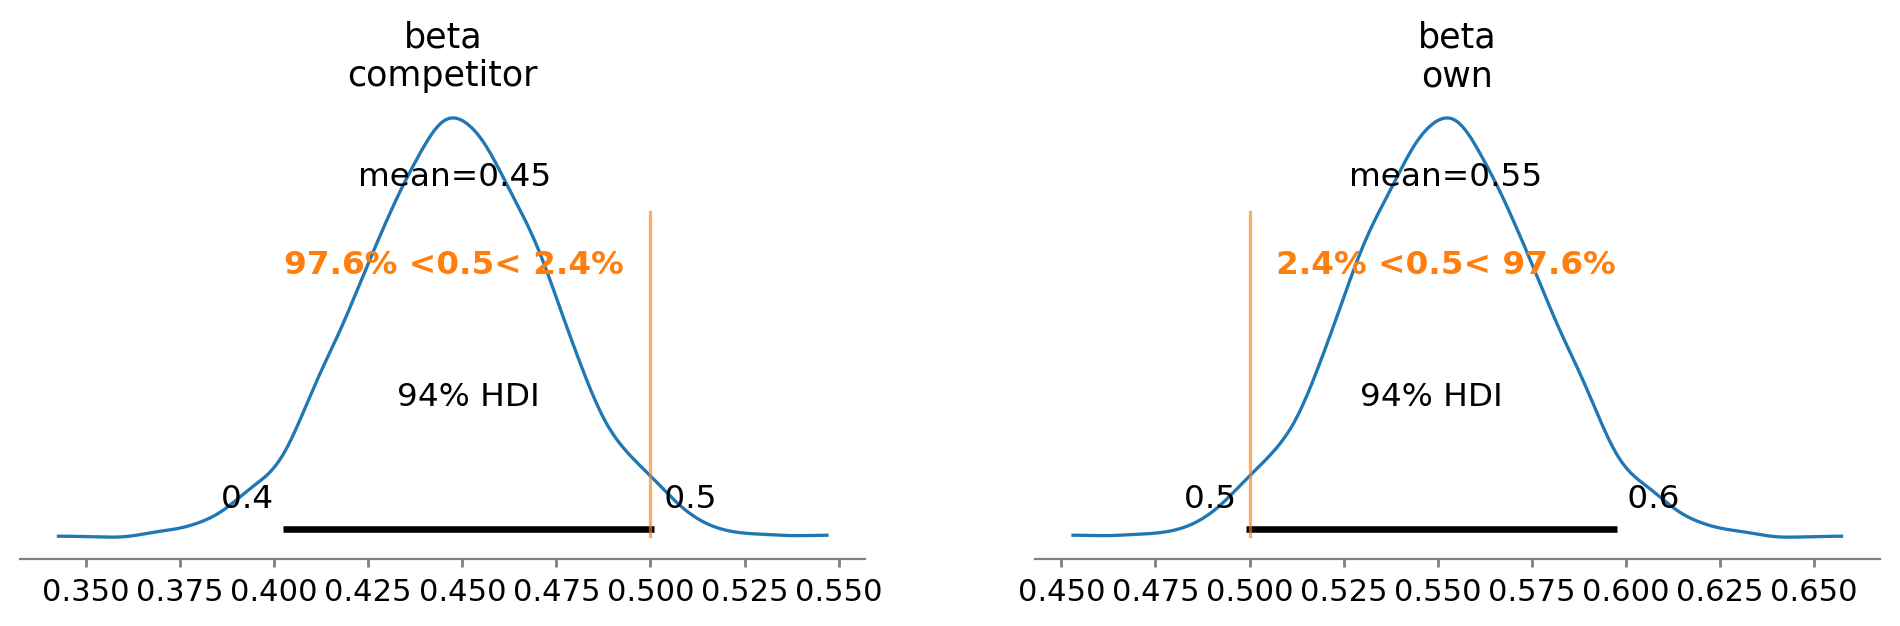

In [17]:
az.plot_posterior(
    result.idata, var_names=["beta"], ref_val=0.5, textsize=11, figsize=(12, 3)
);

## Summary